In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import h5py 
import datetime
import glob
import copy
from cartopy.io.shapereader import Reader
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

In [40]:
nx=50
ny=50

latmin = 19.1
latmax = 19.8
lonmin = -99.5
lonmax = -98.7
footprintradio = 5.0/110.0
pathname = 'f:\\CCA\\NASAGESDISC\\OCO3L2Lite\\mexico2\\mexico2_oco3_lite_2020*.h5'
targetname = 'fossil0036'
name = '/xco2'
psurf = '/Retrieval/psurf'
xco2altz = 412.4
psurfaltz = 633.72
dxco2 = 1
xco2ml = 0

In [3]:
def compilealldatatarget(lats,lons,filelist,footprintradio,targetname):
    
    minlat = (min(lats)-footprintradio/110.0)
    maxlat = (max(lats)+footprintradio/110.0)
    minlon = (min(lons)-footprintradio/110.0)
    maxlon = (max(lons)+footprintradio/110.0)
    
    ilats = np.arange(int(maxlat)-int(minlat)+1,dtype=int)+int(minlat)
    ilons = np.arange(int(maxlon)-int(minlon)+1,dtype=int)+int(minlon)


    for ifile,filename in enumerate(filelist):
        datos = h5py.File(filename,'r')
        #print(ifile)
        for lat in ilats:
            for lon in ilons:
                #print(lat,lon)
                try:
                    gridname = '%iN%iW' % (lat,lon)
                    #print(gridname)
                    lt = datos[gridname]['lat'][()]
                    ln = datos[gridname]['lon'][()]
                    #print(ln)
                    tid = datos[gridname]['/Sounding/target_id'][()] 
                    tname = datos[gridname]['/Sounding/target_name'][()]
                    tidstr = tid.astype('U')
                    tnamestr = tname.astype('U')
                    mask = ((lt <= maxlat) & (lt >= minlat) & \
                           (ln <= maxlon) & (ln >= minlon) & \
                           (tidstr == targetname))
                    #print(mask)
                    data_inter = datos[gridname][mask]
                    #print(data_inter)
                    
                    try:
                        data = np.append(data,data_inter)
                        #print('matrix exists')
                    except:
                        data = copy.copy(data_inter)
                        #print(data)
                        #print('new matrix')
                    print(data.shape)
                except:
                    print('exception: no dataset')
                #print 'data:',len(data)
                #print max(data['lat']), min(data['lat']), max(data['lon']), min(data['lon'])

        datos.close()
    #plt.plot(data['lon'],data['lat'],'.')
    #plt.show()
    return data


In [4]:
def makematrixfromcompileddata(lats,lons,data,name,footprintradio,flag=''):
    
    #print 'data:'
    #print max(data['lat']), min(data['lat']), max(data['lon']), min(data['lon'])
    matrix=np.zeros((len(lons),len(lats)),dtype=np.float64)
    countermatrix=np.zeros((len(lons),len(lats)),dtype=int)
    stdmatrix=np.zeros((len(lons),len(lats)),dtype=np.float64)
    for ilat,lat in enumerate(lats):
        for ilon,lon in enumerate(lons):
            distances2=np.array((data['lat']-lat)**2+(data['lon']-lon)**2)
            conditions=(footprintradio**2 > distances2)
            #print(conditions)
            index=np.where(conditions)[0]
            if len(index) > 0:
                vec=data[name][index]
                #print(vec)
                matrix[ilon,ilat]=np.average(vec)
                #print(matrix[ilon,ilat],ilon,ilat)
                stdmatrix[ilon,ilat]=np.std(vec)
                countermatrix[ilon,ilat]=len(vec)
            else:
                #print(matrix[ilon,ilat],ilon,ilat)
                pass
                #plt.plot(data['lon'],data['lat'],'b.')
                #plt.plot([lon],[lat],'ro')
                #plt.show()
    errmatrix=stdmatrix/np.sqrt(countermatrix)
    #print(matrix)
    if flag=='full':
        return matrix.T,stdmatrix.T, errmatrix.T
    else:
        return matrix.T


In [5]:
def matrixforinterval(tmin,tmax,dataorg):
    index=np.where(np.logical_and(tmin < dataorg['tepoch'],tmax > dataorg['tepoch']))[0]
    data=dataorg[index]
    matrix=makematrixfromcompileddata(lats,lons,data,name,footprintradio)
    return matrix


In [6]:
to=datetime.datetime.utcfromtimestamp(0.0)

lats=latmin+(latmax-latmin)*np.arange(ny)/(ny-1)
lons=lonmin+(lonmax-lonmin)*np.arange(nx)/(nx-1)


lista=glob.glob(pathname)
#print(lista)

data = compilealldatatarget(lats,lons,lista,footprintradio,targetname)
print(data.shape)

if dxco2 == 1:
    data[name] = (data[name]-xco2altz)

if xco2ml == 1:
    data[name] = (data[name]*data[psurf]-xco2altz*psurfaltz)/(data[psurf]-psurfaltz)


(0,)
(0,)
(104,)
(342,)
(799,)
(1089,)
(1538,)
(1816,)
(2143,)
(2347,)
(2349,)
(2351,)
(2351,)


In [41]:
tmin=(datetime.datetime(2020,6,4,0,0,0)-to).total_seconds()
tmax=(datetime.datetime(2020,6,7,0,0,0)-to).total_seconds()
matrix=matrixforinterval(tmin,tmax,data)
np.save('matrixDelta0605',matrix)

<ipython-input-4-79fc48e9d3a4>:27: RuntimeWarning: invalid value encountered in true_divide
  errmatrix=stdmatrix/np.sqrt(countermatrix)


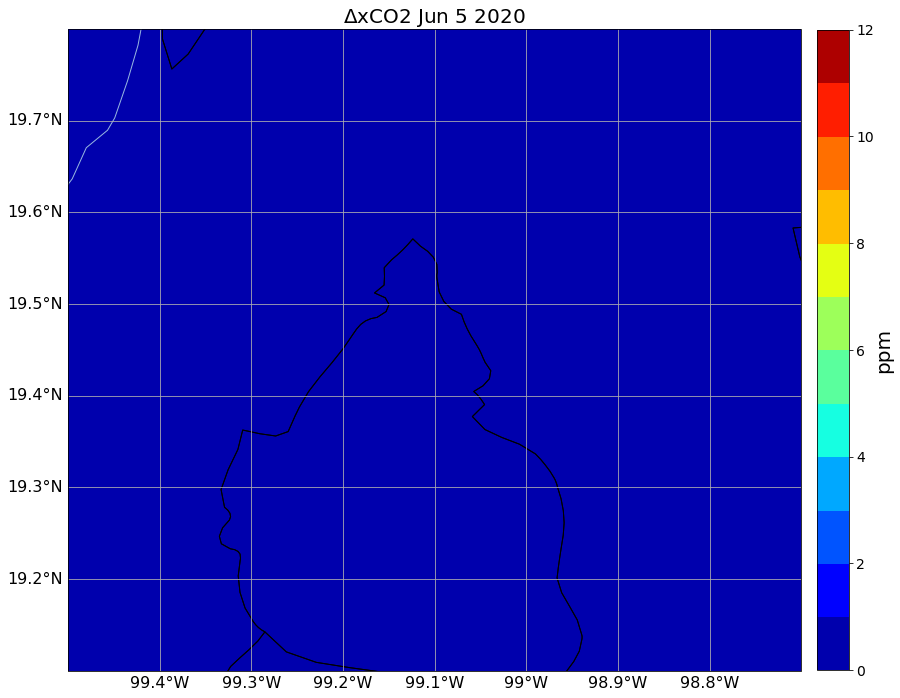

In [42]:
plt.figure(figsize=(14,14))
fontsize = 20
ticksize = 14
# Creates the map
mxmap = plt.axes(projection=ccrs.PlateCarree())

mxmap.add_feature(cfeature.LAND)
mxmap.add_feature(cfeature.OCEAN)
mxmap.add_feature(cfeature.COASTLINE)
mxmap.add_feature(cfeature.BORDERS, linestyle=':')
mxmap.add_feature(cfeature.LAKES, alpha=0.5)
mxmap.add_feature(cfeature.RIVERS)
mxmap.add_feature(cfeature.STATES.with_scale('10m'))
mxmap.set_extent((-99.5,-98.7,19.1,19.8))
#mxmap.xaxis.set_visible(True)
#mxmap.yaxis.set_visible(True)

glines = mxmap.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
glines.xformatter = LongitudeFormatter()
glines.yformatter = LatitudeFormatter()
glines.top_labels = None
glines.right_labels = None
glines.xlabel_style = {'size': 16}
glines.ylabel_style = {'size': 16}

lvls = np.arange(0,13,1)
plt.contourf(lons, lats, matrix, levels = lvls,cmap=plt.get_cmap("jet"),
             transform=ccrs.PlateCarree())
plt.title("$\Delta$xCO2 Jun 5 2020",size=fontsize)
plt.xlabel("Longitude",size=fontsize)
plt.ylabel("Latitude",size=fontsize)
cbar= plt.colorbar(fraction=0.041, pad=.02)
cbar.set_label("ppm", size=fontsize, labelpad=0.8)
cbar.ax.tick_params(labelsize=ticksize)
plt.savefig('f:\\gitCCA\\cca-jupyter\\figures\\xco2_delta_0605.png')
plt.show()

In [75]:
m1 = np.load('matrixML0208.npy')
m2 = np.load('matrixML0326.npy')
m3 = np.load('matrixML0330.npy')
m4 = np.load('matrixML0411.npy')
m5 = np.load('matrixML0420.npy')
m6 = np.load('matrixML0428.npy')
m7 = np.load('matrixML0502.npy')
m8 = np.load('matrixML0506.npy')
m9 = np.load('matrixML0510.npy')
m10 = np.load('matrixML0524.npy')
m11 = np.load('matrixML0605.npy')

matrix = (m1+m2+m3+m4+m5+m6+m7+m8+m9+m10+m11)
print(matrix)
                    

[[ 80.36942759 122.79867153 122.31263568 ...  39.03245424   0.
    0.        ]
 [ 80.57608274 161.24099648 160.99855222 ...  39.42321592   0.
    0.        ]
 [161.20434057 161.05626363 160.75488156 ...  39.74046828   0.
    0.        ]
 ...
 [119.80635064 160.87953671 159.96189763 ... 116.65911094 116.82449749
   77.44188842]
 [ 79.26412092 118.66324991 118.66795281 ... 117.75270637 117.87123535
   39.0143533 ]
 [ 39.86037724  79.08553172  79.00600544 ...  79.13917828  40.56162663
    0.        ]]
